## Sentiment Analysis on Twitter Data
in this notebook i did step-by-step process of performing sentiment analysis using python

the Twitter Data contains the following 6 fields:

     1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive).
     2. ids: The id of the tweet ( 2087).
     3. date: the date of the tweet.
     4. flag: The query (lyx). If there is no query, then this value is NO_QUERY.
     5. user: the user that tweeted.
     6. text: the text of the tweet.


## Step1: Importting Libraries

In [1]:
## importing libraries
## data manipulation
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf
import matplotlib.pyplot as plt


## methods and creating a stopwords set for text processing
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

## machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings("ignore")

print("Tensorflow Version",tf.__version__)

!python -V

Tensorflow Version 2.1.0
Python 3.7.11


[nltk_data] Downloading package stopwords to /home/msc1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Preprocessing
In this notebook, I am using Sentiment-140 from Kaggle. It contains a labels data of 1.6 Million Tweets and I find it a good amount of data to train our model.

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


You can see the columns are without any proper names. Lets rename them for our reference

In [3]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


i am going to train only on text to classify its sentiment. So i can remove the rest of the useless columns.

In [4]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Here are decoding the labels. We map 0 -> Negative and 1 -> Positive as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution. Because it's important that we have almost small amount of examples for given classes.

Text(0.5, 1.0, 'Sentiment Data Distribution')

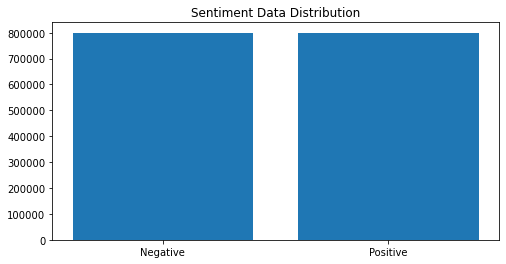

In [6]:
val_count = df.sentiment.value_counts()

%matplotlib inline
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness. Thank kaggle.

Now let us explore the data we having here...

In [7]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10) # Returns the rows with the index and display it

,sentiment,text
860086,Positive,And now I will finally add to the three hours ...
1419846,Positive,"@sacret86 That's ok, I'll be leaving in a few ..."
1096229,Positive,halo song...reminds me of?.... idk but michael...
197138,Negative,caught a well-sized snapper. But also caught a...
289274,Negative,What a complete waste of a beautiful day
1111151,Positive,*sigh...i just had the most amazing baked shri...
600843,Negative,is unhappy ...unhappy ...unhappy ...never met ...
1341993,Positive,@everlastinglamp seriously!!!
682167,Negative,Ugh i feel like my dreams are right in front o...
1105749,Positive,movie day today!!!


Looks like we have a nasty data in text. Because in general we use lot of punctuations and other words without any contextual meaning. It have no value as feature to the model we are training. So we need to get rid of them.



## Text Preprocessing
Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods. Let's continue

### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as write, writing and writes. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

## Hyperlinks and Mentions
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

## Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some stopwords are...

NLTK is a python library which got functions to perform text processing task for NLP.

In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [10]:
df.text = df.text.apply(lambda x: preprocess(x))

## Positive Words

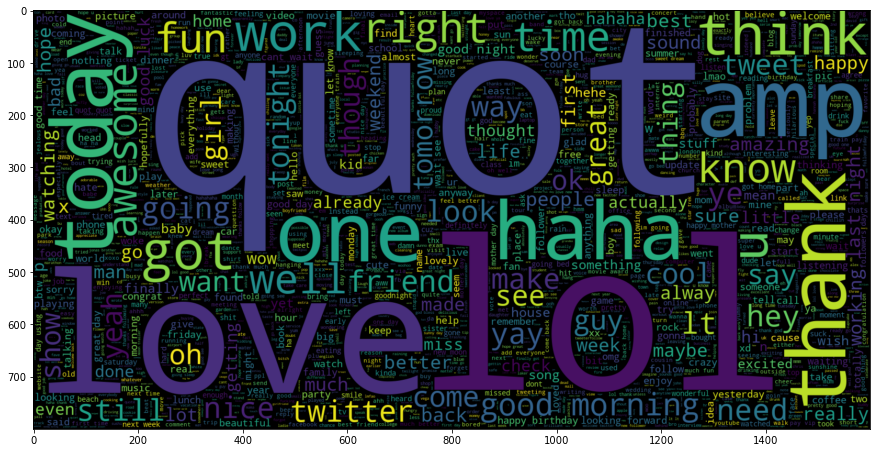

In [11]:
from wordcloud import WordCloud

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Negative Words

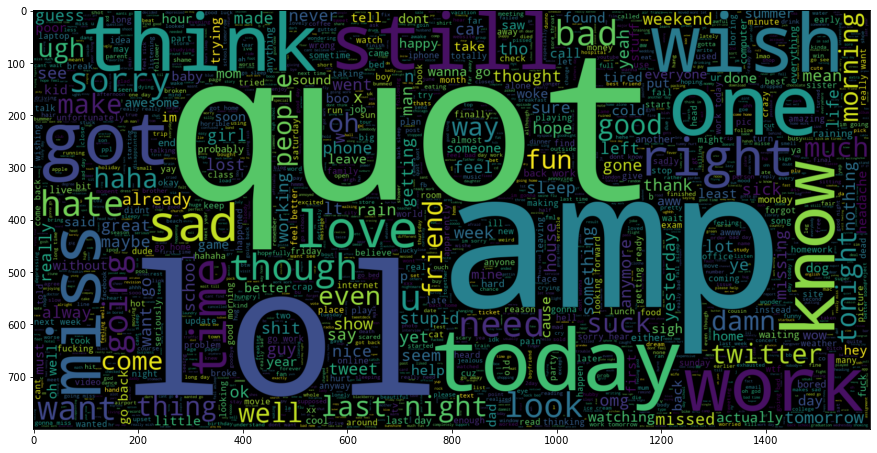

In [12]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

## Train and Test Split

In [13]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [14]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


train_test_split will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [15]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going 3k 13 min missed 5k turn ended...
1181490,Positive,u gonna shows ny soon luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need 2 see ur mom calls back first rememb...
1235876,Positive,sounds like cup tea sign
717314,Negative,tired want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back mi...


## Tokenization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. The process is called Tokenization.

tokenizer create tokens for every word in the data corpus and map them to a index using dictionary.

word_index contains the index for each word

vocab_size represents the total number of word in the data corpus

In [16]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Using TensorFlow backend.


Vocabulary Size : 290575


Now we got a tokenizer object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from pad_sequence to do our job. It will make all the sequence in one constant length MAX_SEQUENCE_LENGTH.

In [17]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [18]:
labels = train_data.sentiment.unique().tolist()

## Label Encoding
We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [19]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


## Word Emdedding
In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification. If you want to learn more about the Word Embedding, please refer some links that I left at the end of this notebook.

In this notebook, I use GloVe Embedding from Stanford AI glove.twitter.27B.zip which can be found at https://nlp.stanford.edu/projects/glove/

In [20]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

In [21]:
GLOVE_EMB = 'glove.twitter.27B.200d.txt'
EMBEDDING_DIM = 200
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = 'project/best_model.hdf5'

In [22]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 1193514 word vectors.


In [23]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [24]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)

## Model Training - LSTM
We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use Sequence Models.

## Sequence Model
Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction.

For model architecture, we use

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) Conv1D Layer - Its using to convolve data into smaller feature vectors.

3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) Dense - Fully Connected Layers for classification

In [25]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

## Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent.
## Callbacks
Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

* LRScheduler - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

* ModelCheckPoint - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,min_lr = 0.01,monitor = 'val_loss',verbose = 1)

In [28]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [29]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Train on 1280000 samples, validate on 320000 samples
Epoch 1/10
1280000/1280000 [==============================] - 48s 38us/sample - loss: 0.4970 - accuracy: 0.7547 - val_loss: 0.4609 - val_accuracy: 0.7798
Epoch 2/10
1280000/1280000 [==============================] - 46s 36us/sample - loss: 0.4717 - accuracy: 0.7727 - val_loss: 0.4551 - val_accuracy: 0.7820
Epoch 3/10
1280000/1280000 [==============================] - 45s 35us/sample - loss: 0.4629 - accuracy: 0.7784 - val_loss: 0.4498 - val_accuracy: 0.7866
Epoch 4/10
1280000/1280000 [==============================] - 46s 36us/sample - loss: 0.4578 - accuracy: 0.7813 - val_loss: 0.4456 - val_accuracy: 0.7890
Epoch 5/10
1280000/1280000 [==============================] - 46s 36us/sample - loss: 0.4536 - accuracy: 0.7838 - val_loss: 0.4445 - val_accuracy: 0.7895
Epoch 6/10
1280000/1280000 [==============================] - 45s 35us/sample - loss: 0.4510 - accuracy: 0.7858 - val_loss: 0.4445 - val_accuracy: 0.7896
Epoch 7/10
1280000/1280

## Model Evaluation
Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

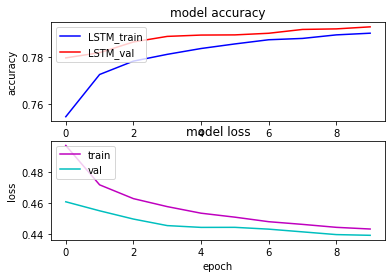

In [30]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as POSITIVE sentiment.

In [31]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

320000/320000 [==============================] - 2s 7us/sample


## Confusion Matrix
Confusion Matrix provide a nice overlook at the model's performance in classification task

In [32]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

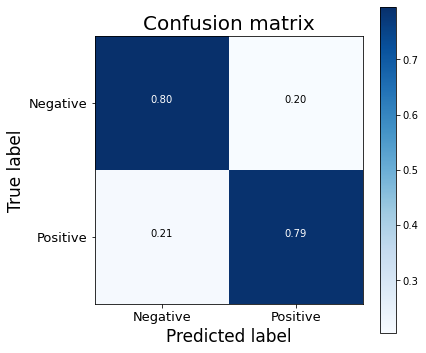

In [33]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

## Classification Scores

In [34]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.80      0.79    160542
    Positive       0.79      0.79      0.79    159458

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



## saving finel model into hdf5 & h5 formets

In [35]:
from keras.models import load_model

model.save('saved_model/my_model.hdf5')
model.save('saved_model/my_model.h5')